In [1]:
%%capture
!pip install --upgrade openpmd-beamphysics pydantic

In [2]:
import requests
import numpy as np
import time
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import pyvista as pv
import os
from pmd_beamphysics import ParticleGroup
import pydantic

In [3]:
os.chdir('..')
from astra_web.generator.schemas import Particles
from astra_web.simulation.schemas import XYEmittanceTable, ZEmittanceTable

In [4]:
def to_pmd(particles: pd.DataFrame) -> ParticleGroup:
    data = particles.copy()
    ref = data.iloc[0]

    data['weight'] = np.abs(data.pop('macro_charge')) * 1e-9
    data.loc[1:, 'z'] = data.loc[1:, 'z'] + ref['z']
    data.loc[1:, 'pz'] = data.loc[1:, 'pz'] + ref['pz']
    data.loc[1:, 't_clock'] = (data.loc[1:, 't_clock'] + ref['t_clock'])*1e-9
    data.loc[data['status'] == 1, 'status'] = 2
    data.loc[data['status'] == 5, 'status'] = 1
    
    data_dict = data.to_dict('list')
    data_dict['n_particles'] = data.size
    data_dict['species'] = 'electron'
    data_dict['t'] = ref['t_clock']*1e-9

    return ParticleGroup(data=data_dict)

In [24]:
input_filepath = os.path.abspath("./tests/sample/input/out.ini")
output_filepath = os.path.abspath("./tests/sample/output/xfel.0320.001")
solenoid_path = os.path.abspath("./tests/sample/input/Main_and_Buck_sym2.prn")
cavity_path = os.path.abspath("./tests/sample/input/rz_GUN_FEM-003-531-531-filt3.dat")
x_emit_path = os.path.abspath("./tests/sample/output/xfel.Xemit.001")
y_emit_path = os.path.abspath("./tests/sample/output/xfel.Yemit.001")
z_emit_path = os.path.abspath("./tests/sample/output/xfel.Zemit.001")

In [6]:
input_df = pd.read_fwf(input_filepath, names=list(Particles.model_fields.keys()))
input_particles = to_pmd(input_df)

In [7]:
output_df = pd.read_fwf(output_filepath, names=list(Particles.model_fields.keys()))
output_particles = to_pmd(output_df)

## Electromagnetic fields

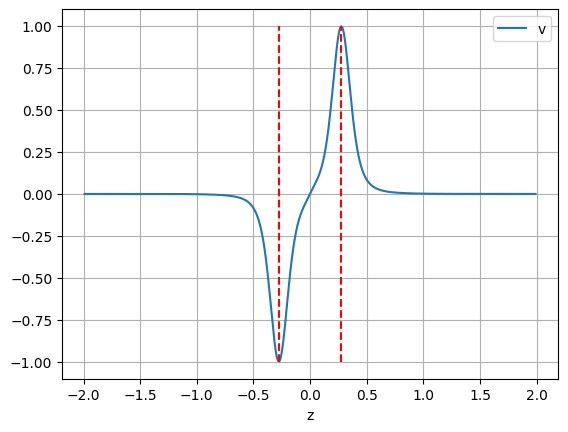

In [62]:
solenoid_df = pd.read_csv(solenoid_path, names=['z', 'v'], sep=' ')
solenoid_df.plot('z', 'v')
plt.vlines(x=0.276, ymin=-1, ymax=1, color='r', linestyles="dashed")
plt.vlines(x=-0.276, ymin=-1, ymax=1, color='r', linestyles="dashed")
plt.grid()
plt.show()

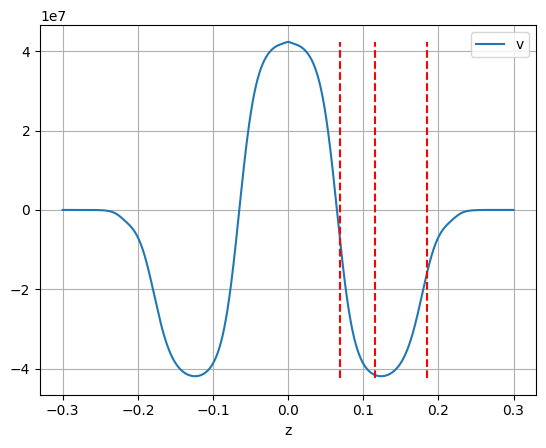

In [59]:
L = 0.1154
H = cavity_df.max()['v']
cavity_df.plot('z', 'v')
plt.vlines(x=L, ymin=-H, ymax=H, color='r', linestyles="dashed")
plt.vlines(x=0.6*L, ymin=-H, ymax=H, color='r', linestyles="dashed")
plt.vlines(x=1.6*L, ymin=-H, ymax=H, color='r', linestyles="dashed")
plt.grid()
plt.show()

## Side views

### Input distribution

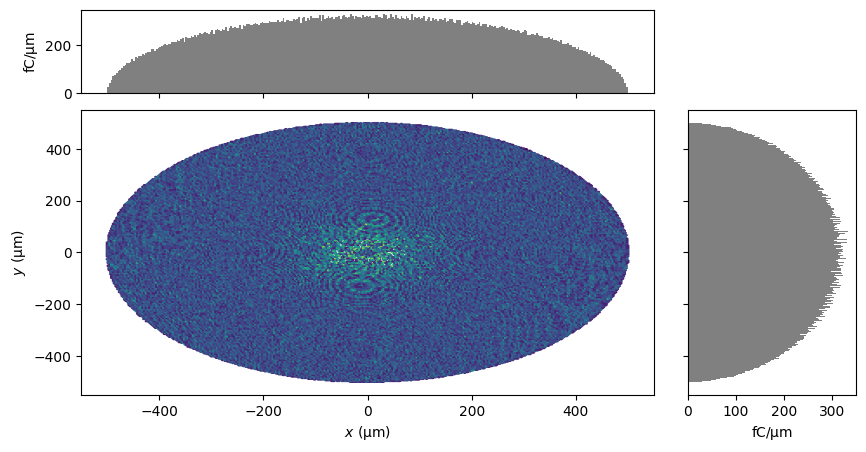

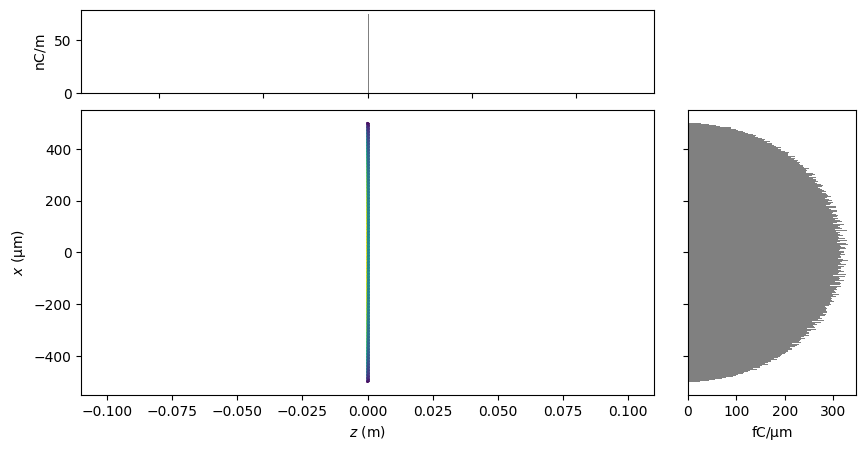

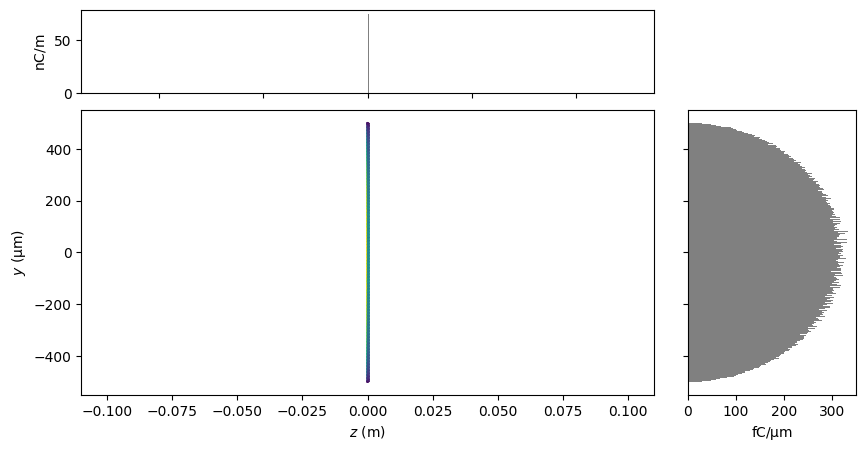

In [8]:
input_particles.plot('x', 'y', bins=300, figsize=(10, 5))
input_particles.plot('z', 'x', bins=300, figsize=(10, 5))
input_particles.plot('z', 'y', bins=300, figsize=(10, 5))

### Output distribution

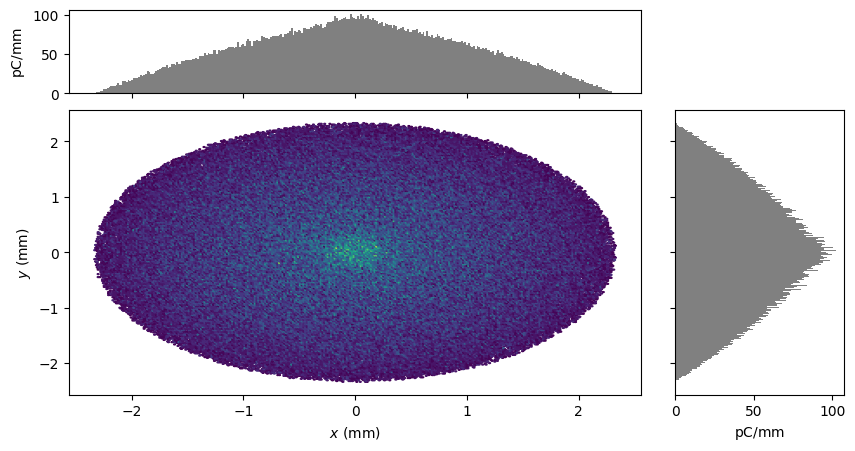

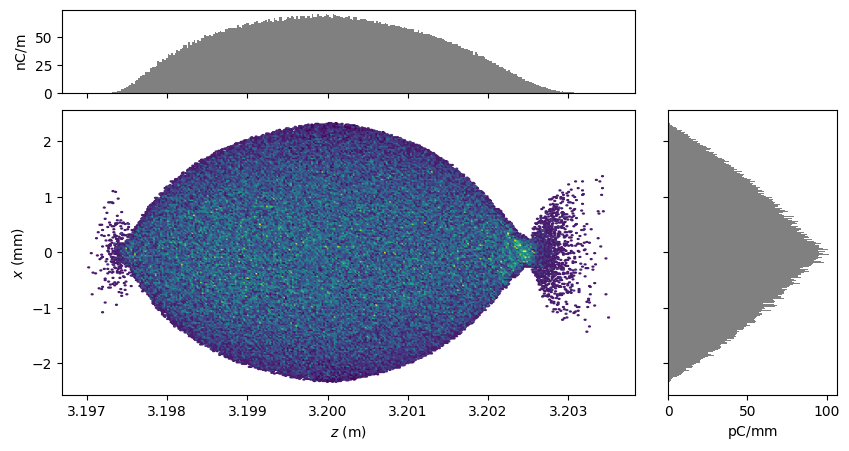

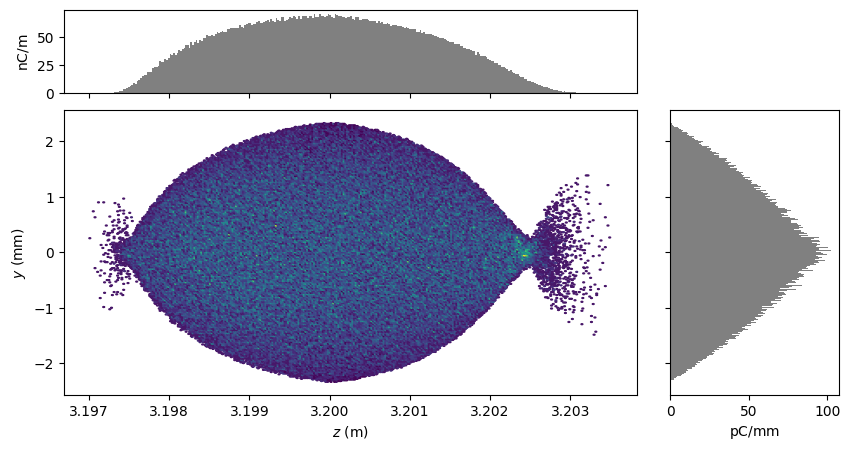

In [9]:
output_particles.plot('x', 'y', bins=300, figsize=(10, 5))
output_particles.plot('z', 'x', bins=300, figsize=(10, 5))
output_particles.plot('z', 'y', bins=300, figsize=(10, 5))

## Phase spaces

### Input distribution

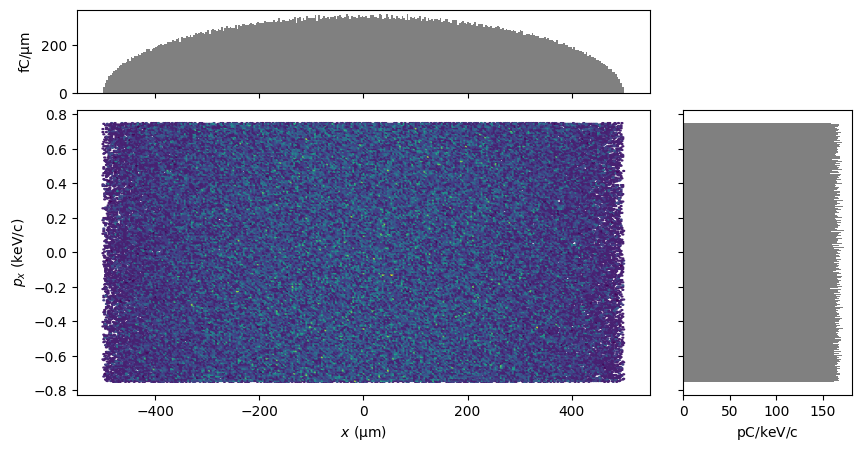

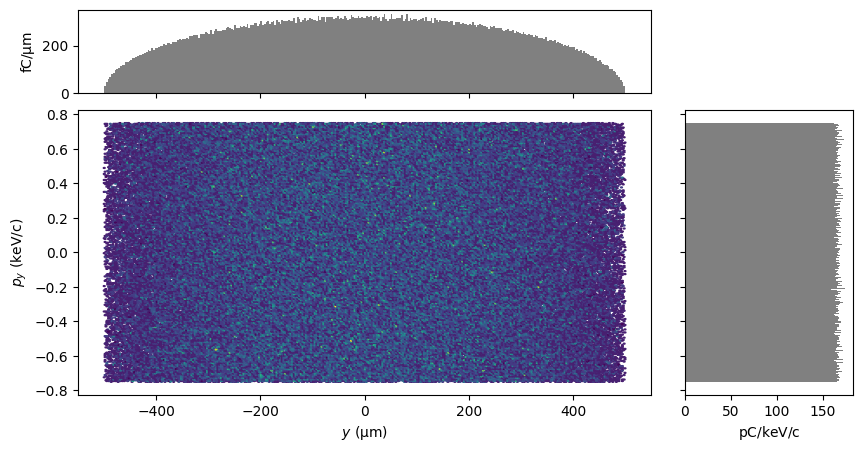

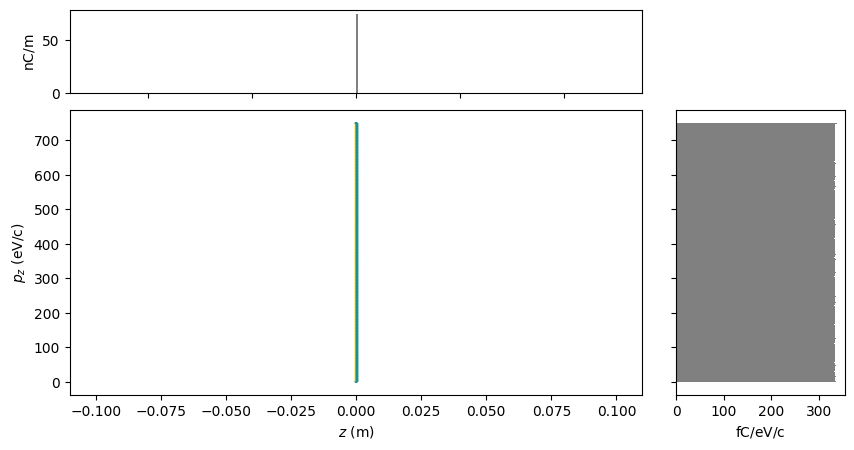

In [10]:
input_particles.plot('x', 'px', bins=300, figsize=(10, 5))
input_particles.plot('y', 'py', bins=300, figsize=(10, 5))
input_particles.plot('z', 'pz', bins=300, figsize=(10, 5))

### Output distribution

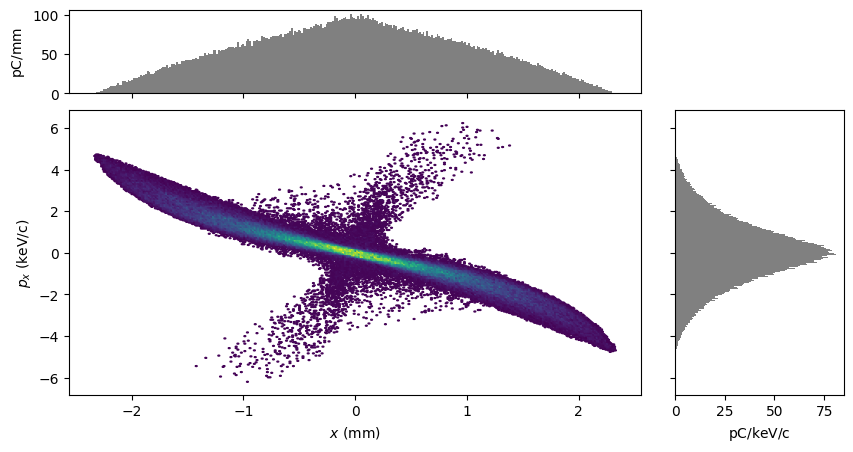

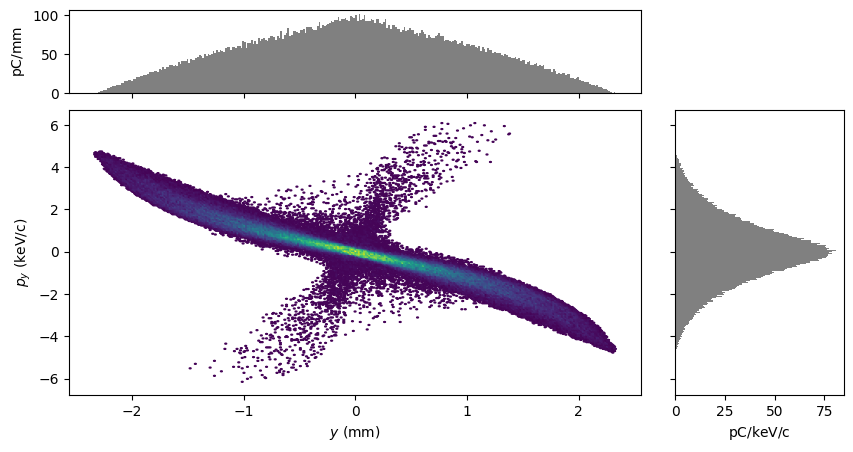

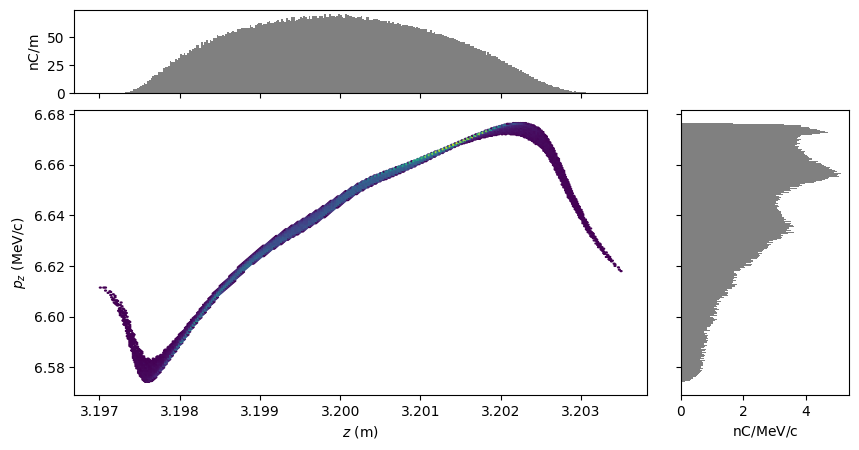

In [11]:
output_particles.plot('x', 'px', bins=300, figsize=(10, 5))
output_particles.plot('y', 'py', bins=300, figsize=(10, 5))
output_particles.plot('z', 'pz', bins=300, figsize=(10, 5))

## Emittance

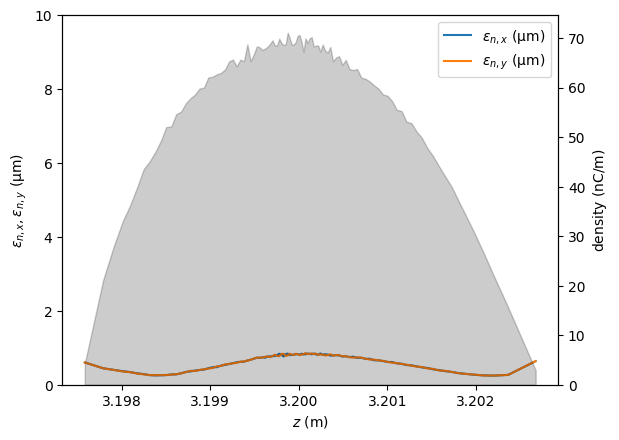

In [12]:
output_particles.slice_plot('norm_emit_x', 'norm_emit_y', ylim=(0, 1e-5))

<Axes: xlabel='z'>

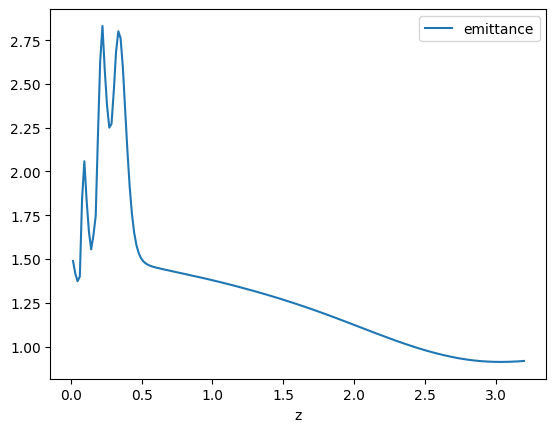

In [13]:
emit_x = pd.read_fwf(x_emit_path, names=list(XYEmittanceTable.model_fields.keys()))
emit_x.plot(x='z', y='emittance')

<Axes: xlabel='z'>

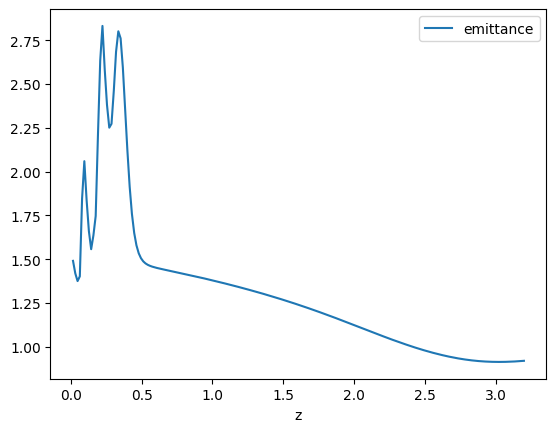

In [14]:
emit_y = pd.read_fwf(y_emit_path, names=list(XYEmittanceTable.model_fields.keys()))
emit_y.plot(x='z', y='emittance')

<Axes: xlabel='z'>

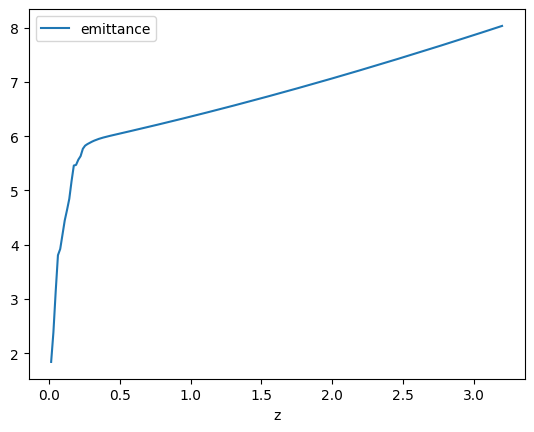

In [15]:
emit_z = pd.read_fwf(z_emit_path, names=list(ZEmittanceTable.model_fields.keys()))
emit_z.plot(x='z', y='emittance')

In [16]:
# request URL pointing to locally running service
# REQUEST_URL = "http://0.0.0.0:8000/" 
REQUEST_URL = "http://black/astra/" 
# headers include API key secret for authentication
REQUEST_HEADERS = {'Content-Type': 'application/json', 'x-api-key': os.getenv("ASTRA_API_KEY")}

def request(endpoint, data={}, request_type="post"):
    url = REQUEST_URL + endpoint
    request_func = getattr(requests, request_type)
    response = request_func(url=url, headers=REQUEST_HEADERS, json=data)
    print(f"Request [{request_type.upper()}] {url} returned with code {response.status_code}\n")

    return response.json()

In [23]:
response = request("particles/x_fel_test", data=input_df.to_dict("list"))
response

Request [POST] http://black/astra/particles/x_fel_test returned with code 200



{'filename': 'x_fel_test'}

In [20]:
response = request("particles/x_fel_test", request_type='get')

Request [GET] http://black/astra/particles/x_fel_test returned with code 200



In [21]:
pd.DataFrame(response)

,x,y,z,px,py,pz,t_clock,macro_charge,species,status
0,0.000000,0.000000,0.0,0.000,0.00,749.740,0.000000,9.999984e-07,1,-1
1,0.000125,0.000000,0.0,0.000,0.00,0.000,0.001500,1.200000e-06,1,-3
2,0.000000,0.000125,0.0,0.000,0.00,0.000,-0.001500,1.200000e-06,1,-3
3,0.000250,0.000000,0.0,0.000,0.00,0.000,0.003000,1.200000e-06,1,-3
4,0.000000,0.000250,0.0,0.000,0.00,0.000,-0.003000,1.200000e-06,1,-3
...,...,...,...,...,...,...,...,...,...,...
249994,-0.000264,0.000277,0.0,-694.650,143.23,-507.450,0.000010,2.000000e-07,1,-1
249995,-0.000380,0.000128,0.0,-618.720,-238.53,-400.350,-0.000469,2.000000e-07,1,-1
249996,-0.000414,-0.000066,0.0,-350.990,-479.87,-293.240,0.000306,2.000000e-07,1,-1
249997,-0.000350,-0.000261,0.0,-29.727,-493.38,-186.140,-0.000131,2.000000e-07,1,-1


In [22]:
response = request("particles/x_fel_test", request_type='delete')

Request [DELETE] http://black/astra/particles/x_fel_test returned with code 200



In [64]:
simulation_parameters = {
    'run_specs': {
        'particle_file_name': 'x_fel_test',
        'thread_num': 25
    },
    'output_specs': {
        'z_stop': 3.2,
        'z_emit': 20
    },
    'space_charge': {
        'use_space_charge': True,
    },
    'cavities': [
        {
            'max_field_strength': 58.1,
            'field_table': cavity_df.to_dict("list"),
            'frequency': 1.3,
            'phase': 2.0,
        }
    ],
    'solenoids': [
        {
            'max_field_strength': 0.21852, 
            'field_table': solenoid_df.to_dict("list")
        }
    ]
}

In [ ]:
response = request("simulate", data=simulation_parameters)